In [236]:
#import libraries
import pandas as pd
import numpy as np
import pickle           # save file
import re
import nltk
import pickle                           
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /Users/hamza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/hamza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [237]:
# Loading the data with labels for training model 
data = pd.read_csv('https://raw.githubusercontent.com/ANKITSHARMA98/Restaurant-Review-s-Sentiment-Analyser/main/Restaurant_Reviews.tsv', delimiter='\t', quoting=3)
data.head(5)


,Review,Liked
0,Awesome.,1
1,Wow... Loved this place.,1
2,Crust is not good.,0
3,Not tasty and the texture was just nasty.,0
4,Stopped by during the late May bank holiday of...,1


In [238]:
#function to pre-process data using NLP techniques
def NLP_Process(dt):
    corpus = []
    for i in range (len(dt)):
        # Remove specical characters from each review text
        each_review = re.sub(pattern='[^a-zA-Z]', repl=" ", string=dt["Review"][i])

        # Convert each review to lower case
        each_review = each_review.lower()

        # tokenize each-review text
        review_words = each_review.split()

        #Removing the stop words
        review_words = [word for word in review_words if not word in set(stopwords.words('english'))]

        ##print(review_words)

        #Lemmatizing review_words
        Lm = WordNetLemmatizer()
        each_review = [Lm.lemmatize(word) for word in review_words]

        #joinning the lemmatized words
        each_review = " ".join(each_review)

        #create a corpus
        corpus.append(each_review)
    return corpus

In [239]:
#create data corpus with pre-processing of review
corp_one = NLP_Process(data)

In [240]:
# Creating a Bag of words model
from sklearn.feature_extraction.text import CountVectorizer

CV = CountVectorizer()
X = CV.fit_transform(corp_one).toarray()
y = data["Liked"]

# Creating a pickle file for the CountVectorizer for future use
pickle.dump(CV, open('cv-transform.pkl', 'wb'))

In [241]:
# Model Building
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha=0.2)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.2, class_prior=None, fit_prior=True)

In [242]:
#Naive Bayes Score
classifier.score(X_test,y_test)

0.7611940298507462

In [243]:
#Fitting Logistic Regression
from sklearn.linear_model import LogisticRegression
LRM = LogisticRegression(C=1.5)
LRM.fit(X_train,y_train)

/Users/hamza/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [244]:
#Logistic regression Score
LRM.score(X_test,y_test)

0.7860696517412935

In [245]:
#Fitting Support Vector Regressor
from sklearn.svm import SVC
svc = SVC(kernel="linear", C=1.5)
svc.fit(X_train,y_train)

SVC(C=1.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [246]:
#Support Vector Regressor Score
svc.score(X_test,y_test)

0.7810945273631841

In [247]:
#dump all models using pickle
pickle.dump(classifier, open('review-sentiment-MNB-model.pkl', 'wb'))
pickle.dump(classifier, open('review-sentiment-LR-model.pkl', 'wb'))
pickle.dump(classifier, open('review-sentiment-SVC-model.pkl', 'wb'))


In [248]:
#real-time restaurant data obtained through Just Eat web scraping 
#trained model will be used on this data to perform predictions
df = pd.read_csv("Review.csv")
#print(len(df))
df = df[~(df["Review"]=="None")]
#print(len(df))
df.dropna(inplace=True)
#print(len(df))
df = df.reset_index(drop=True)
df.head(5)

,Customer_Name,Date,Review
0,William,03/04/2022,Super duper tasty!
1,Bart,31/03/2022,This is the first time I’ve ordered from this ...
2,Xin,29/03/2022,The food wasn't bad but didn't taste as good a...
3,sagar,26/03/2022,"I ordered 4 dishes totalling £24 , didn't even..."
4,Bee,20/03/2022,"First time ordering, great food and really aut..."


In [249]:
#Real time data from a takeaway on just eat pre-processed
corp_two = NLP_Process(df)

#vectorize real data review text
df_vect = CV.transform(corp_two).toarray()

#predict real reviews
prediction = LRM.predict(df_vect)


In [250]:
#store predcition as a new column in df
df["Prediction"] = prediction

(array([125.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 248.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

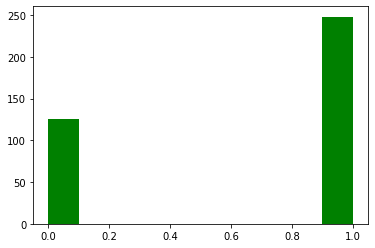

In [252]:
#plot predcitions
plt.hist(df["Prediction"],color=["green"])

In [253]:
#create a new column with positive or negative label
df["Review_Type"] = df["Prediction"].apply(lambda x: "positive" if x == 1 else "Negative")

In [254]:
#write df as csv file
df.drop("Prediction", axis=1, inplace=True)
df.to_csv("Prediction.csv", index=False)